# Entrance Challenge: When Will the Sakura Bloom?

***

**Name：Hoang Loc NGUYEN**

**Email: hoangloc0402@gmail.com**

**Submission Date：Mar 12th 2019**

***

In [0]:
import urllib
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.metrics import r2_score as sklearn_r2_score
from copy import deepcopy as clone
from datetime import date as date_t
from itertools import cycle
from keras.utils import to_categorical as one_hot
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adagrad

In [0]:
def get_num_day_between(start_day, end_day):
    delta = end_day - start_day
    return delta.days

In [0]:
def r2_score(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    SS_total = sum([(y-y_true_mean)**2 for y in y_true])
    SS_res = sum([(yi-fi)**2 for yi, fi in zip(y_true, y_pred)])
    return 1 - SS_res/SS_total

In [0]:
# I run this ipynb on Google Colab so i need to mount the data
from google.colab import drive
drive.mount('/content/drive')

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2017 using the Japanese Meteorological Agency website (気象庁).

In [5]:
# Prepare urls for getting sakura blooming date data from JMA
url_prefix = "https://www.data.jma.go.jp/sakura/data/sakura003_0"
url_postfix = ".html"
urls = [url_prefix + str(x) + url_postfix for x in range(1,7)]
pprint(urls)

['https://www.data.jma.go.jp/sakura/data/sakura003_01.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_02.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_03.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_04.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_05.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_06.html']


In [0]:
# Function for getting data from one url of JMA website
re.DOTALL = False
def parse_url(url_input):
    fp = urllib.request.urlopen(url_input)
    raw_html_str = fp.read().decode("utf8")
    fp.close()
    tokyo_line = re.findall("東京 .*\n",  raw_html_str)[0]
    tokyo_num = re.findall("\d.*\d", tokyo_line)[0]
    tokyo_num = tokyo_num.split()[:-2]
    tokyo_num = [int(num) for num in tokyo_num]
    month = tokyo_num[0::2]
    date = tokyo_num[1::2]
    return month, date

In [0]:
# Getting sakura blooming date from the year of 1961 to 2017
bloom_year = range(1961,2018)
bloom_month = list()
bloom_date = list()
for url in urls:
    mon, dat = parse_url(url)
    bloom_month+=mon
    bloom_date+=dat
# Remove 2018
bloom_month = bloom_month[:-1]
bloom_date = bloom_date[:-1]
tokyo_bloom_date_data = list(zip(bloom_year, bloom_month, bloom_date))
tokyo_bloom_date_data_dict = { x[0]:[x[1], x[2]] for x in tokyo_bloom_date_data}

In [8]:
#Create Dataframe from sakura blooming date data
print('Blooming data acquired from JMA website: ')
pd.DataFrame.from_dict({'year':bloom_year, 'month': bloom_month, 'date': bloom_date}).iloc[0:5,]

Blooming data acquired from JMA website: 


,date,month,year
0,1,4,1961
1,1,4,1962
2,1,4,1963
3,2,4,1964
4,2,4,1965


In [0]:
# Read data of Tokyo's weather condition from file
data_path = '/content/drive/My Drive/Colab Notebooks/sakura-blossom/tokyo.csv'
df_tokyo_weather = pd.read_csv(data_path, sep=',')
# I use Google Translate to rename all column labels to English
tokyo_weather_columns = ["index", "year", "month", "date","Local average pressure", 
                         "Sea level average pressure", "Total precipitation", 
                         "1 hour maximum precipitation", "10 minutes Maximum precipitation", 
                         "Average temperature", "Highest temperature", "Lowest Temperature", 
                         "Average humidity", "Minimum humidity", "Sunshine hours"]
df_tokyo_weather.set_axis(tokyo_weather_columns, axis = "columns", inplace=True)

# Convert to Kelvin
for index, row in df_tokyo_weather.iterrows():
  df_tokyo_weather.loc[index, 'Average temperature K'] = row['Average temperature'] + 273.15 

In [10]:
df_tokyo_weather.iloc[0:10]

,index,year,month,date,Local average pressure,Sea level average pressure,Total precipitation,1 hour maximum precipitation,10 minutes Maximum precipitation,Average temperature,Highest temperature,Lowest Temperature,Average humidity,Minimum humidity,Sunshine hours,Average temperature K
0,0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41,15,8.6,275.25
1,1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51,26,8.7,274.65
2,2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58,37,5.4,275.65
3,3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60,38,1.0,277.85
4,4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33,19,8.3,276.95
5,5,1961,1,6,1014.0,1014.7,0.0,0.0,0.0,3.9,8.6,-0.2,54,35,1.4,277.05
6,6,1961,1,7,1018.5,1019.3,0.0,0.0,0.0,3.3,9.1,-0.8,50,28,8.2,276.45
7,7,1961,1,8,1022.7,1023.4,0.3,0.2,0.1,4.0,11.8,-2.0,60,25,7.9,277.15
8,8,1961,1,9,1020.2,1020.9,7.4,2.8,0.9,4.7,6.9,1.8,69,50,0.0,277.85
9,9,1961,1,10,1014.9,1015.6,2.3,0.8,0.2,5.3,6.4,3.5,79,72,0.0,278.45


In [0]:
df_tokyo = clone(df_tokyo_weather)
df_tokyo['is blooming date'] = False

for idx, row in df_tokyo.iterrows():
    year, month, date = row['year'], row['month'], row['date']
    if (year, month, date) in tokyo_bloom_date_data:
        df_tokyo.loc[idx,'is blooming date'] = True

In [0]:
# Split the test and train data
testing_years = [1966, 1971, 1985, 1994, 2008] 
training_years = list(range(1961,2018))
for year in testing_years:
    training_years.remove(year)
    
train_data = df_tokyo[~df_tokyo['year'].isin(testing_years)]
test_data = df_tokyo[df_tokyo['year'].isin(testing_years)]

In [0]:
print(training_years)

[1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

In [0]:
class predictor_600_degree_rule():
    def __init__(self, df_tokyo):
        self.T_mean = 0
        self.df_tokyo = df_tokyo
        self.accumulated_temperature = None
        self.training_years = None
        self.start_month = 2 # February 1st
        self.start_date = 1
        
    # Input a year, a month, a day and get index of that day in df_tokyo
    def get_idx(self, year, month, date):
        idx = self.df_tokyo.loc[(self.df_tokyo['year'] == year) & 
                                 (self.df_tokyo['month'] == month) & 
                                 (self.df_tokyo['date'] == date)].index.tolist()[0]
        return int(idx)  
    
    def fit(self, training_years):
        self.training_years = training_years
        self.accumulated_temperature = list()
        
        df_tokyo_bloom = self.df_tokyo[(self.df_tokyo['is blooming date'] == True) &
                                      (self.df_tokyo['year'].isin(self.training_years))]
        
        for index, row in df_tokyo_bloom.iterrows():
            bloom_year, bloom_month, bloom_date = row['year'], row['month'], row['date']
            idx_start = self.get_idx(bloom_year, self.start_month, self.start_date)
            idx_end = self.get_idx(bloom_year, bloom_month, bloom_date)
        #     Get all daily maximum temperature from February 1st to the actual bloom-date
            all_max_temp = list(self.df_tokyo['Highest temperature'].iloc[idx_start:idx_end + 1,])
            self.accumulated_temperature.append(sum(all_max_temp))
        self.T_mean = np.mean(self.accumulated_temperature)
        
    def plot(self):
        plt.plot(self.training_years, self.accumulated_temperature)
        plt.xlabel('Year')
        plt.ylabel('Accumulated Temperature (°C)')
        plt.title(' Accumulated daily maximum temperature from Feb 1st to the actual bloom-date BDj')
        plt.plot(self.training_years, [600]*len(self.training_years))
        plt.show()
        
    def get_T_mean(self): 
        return self.T_mean
    
    # Predict bloom date for years with a specified threshhold
    def get_bloom_date(self, input_years, threshold):
        bloom_date = list()
        bloom_date_count = list()
        for year in input_years:
            df = self.df_tokyo[(df_tokyo['year'] == year) & 
                               (self.df_tokyo['month'] >= self.start_month)]
            sum_temperature = 0
            for idx, row in df.iterrows():
                sum_temperature += row['Highest temperature']
                if sum_temperature > threshold:
                    num_of_date = idx - self.get_idx(year, self.start_month, self.start_date)
                    bloom_date.append([year, row['month'], row['date']])
                    bloom_date_count.append(num_of_date)
                    break
        return bloom_date, bloom_date_count
    
    def predict_with_T_mean(self, input_years):
        return self.get_bloom_date(input_years, self.T_mean)
    
    def predict_with_600(self, input_years):
        return self.get_bloom_date(input_years, 600)

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

In [317]:
predictor_1st = predictor_600_degree_rule(df_tokyo)
predictor_1st.fit(training_years)

print('T_mean for the training data is: ', predictor_1st.get_T_mean())

T_mean for the training data is:  638.3557692307693


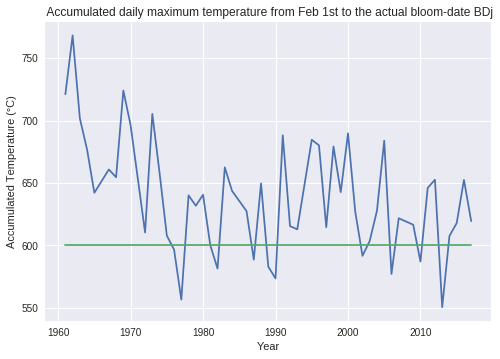

In [318]:
predictor_1st.plot()

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [319]:
# Get number of date from Feb 1st to the predicted blooming date (for both T_mean and 600 degree threshold)
BD_T, BD_count_T = predictor_1st.predict_with_T_mean(testing_years)
BD_600, BD_count_600 = predictor_1st.predict_with_600(testing_years)
print('BD_j predicted with T_mean:     ', BD_T)
print('BD_j predicted with 600 degree: ', BD_600)
print('BD_j count predicted with T_mean:     ', BD_count_T)
print('BD_j count predicted with 600 degree: ', BD_count_600)

BD_j predicted with T_mean:      [[1966, 3, 23], [1971, 3, 29], [1985, 4, 1], [1994, 3, 31], [2008, 3, 25]]
BD_j predicted with 600 degree:  [[1966, 3, 20], [1971, 3, 27], [1985, 3, 29], [1994, 3, 28], [2008, 3, 23]]
BD_j count predicted with T_mean:      [50, 56, 59, 58, 53]
BD_j count predicted with 600 degree:  [47, 54, 56, 55, 51]


In [320]:
 # Input a year, a month, a day and get index of that day in df_tokyo
def get_idx(year, month, date):
    idx = df_tokyo.loc[(df_tokyo['year'] == year) & 
                     (df_tokyo['month'] == month) & 
                     (df_tokyo['date'] == date)][0:1]['index']
    return int(idx)  

# Get the number of date from Feb 1st to the actual blooming date of years in testing years
BD_count_actual = list()
for index, row in test_data.iterrows():
    if not row['is blooming date']:
        continue
    bloom_year, bloom_month, bloom_date = row['year'], row['month'], row['date']
    idx_start = get_idx(bloom_year, 2, 1)
    idx_end   = get_idx(bloom_year, bloom_month, bloom_date)
    BD_count_actual.append(idx_end - idx_start)
    
print('Actual BD_j count: ', BD_count_actual)

Actual BD_j count:  [47, 57, 61, 58, 50]


In [321]:
print('Compute R2 score using self-implemented function:')
print('R2 Score for the threshold of 600:    ',r2_score(BD_count_actual, BD_count_600))
print('R2 Score for the threshold of T_mean: ',r2_score(BD_count_actual, BD_count_T))

Compute R2 score using self-implemented function:
R2 Score for the threshold of 600:     0.6793002915451896
R2 Score for the threshold of T_mean:  0.8323615160349854


In [0]:
# This var is used for comparision later
BD_1st_problem = [x +30 for x in BD_count_T] # D_j is Feb 1st

***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


In [0]:
# Just define some constants
PHI = 35 + 40/60
PHI2 = np.power(PHI,2)
L = 4
lnL = np.log(L)
T_s = 290.15
R = 8.314

In [0]:
# The model class for the whole Problem 2
class predictor_linear_reg_model():
  def __init__(self, df_tokyo):
    self.df_tokyo = df_tokyo
    self.training_years = None
    self.D_j = dict()
    self.T_ij = dict()
    self.t_s = dict()
    self.DTS_j = dict()
    #Convert Kcal to Joule
    self.E_a = [4184*x for x in range(5, 41)] 
    self.E_a_MSE = dict()
    self.df_DTS_j = None
    self.DTS_mean = None
    self.best_Ea = None
    
  #Compute Dj according to Hayashi
  def get_Dj(self, year):
    if year not in self.D_j.keys():
      avg_temp_3_month = self.df_tokyo[(self.df_tokyo['year']==year) &
                         (self.df_tokyo['month']<=3)]['Average temperature']
      T_F = np.mean(avg_temp_3_month)
      self.D_j[year] = int(136.75 - 7.689*PHI + 0.133*PHI2 - 1.307*lnL + 0.144*T_F + 0.285*np.power(T_F,2))
    return self.D_j[year]
    
  def get_T_ij(self, i, j):
    if (i,j) not in self.T_ij.keys():
      df = clone(self.df_tokyo[self.df_tokyo['year']==j])
      df.reset_index(drop=True, inplace = True)
      self.T_ij[(i,j)] = df.iloc[i-1].loc['Average temperature K']
    return self.T_ij[(i,j)]

  def get_t_s(self, E_a, i, j):
    if (E_a, i, j) not in self.t_s.keys():
      T_ij = self.get_T_ij(i, j)
      numer = E_a*(T_ij - T_s)
      denom = R*T_ij*T_s
      self.t_s[(E_a, i, j)] = np.exp(numer/denom)
    return self.t_s[(E_a, i, j)]
    

  def get_DTS_j(self, E_a, year):
    if (E_a, year) not in self.DTS_j.keys():
      df = clone(self.df_tokyo[self.df_tokyo['year']==year])
      df.reset_index(drop=True, inplace = True)
      D_j = self.get_Dj(year)
      BD_j = 0
      for index, row in df.iterrows():
          if row['is blooming date']:
              BD_j = index + 1
              break
      DTS_j = 0
      for i in range(D_j, BD_j):         
          DTS_j += self.get_t_s(E_a, i, year)
      self.DTS_j[(E_a, year)] = DTS_j 
    return self.DTS_j[(E_a, year)]
  
  def fit(self, training_years):
      self.training_years = training_years
      self.df_DTS_j = pd.DataFrame(columns=['E_a', 'mean']+ self.training_years)
      # For every E_a, compute DTS_j for all year in training years and save to a dataframe df_DTS_j 
      for e_a in self.E_a:
        DTS_j = list()
        for year in self.training_years:
            DTS_j.append(self.get_DTS_j(e_a, year))
        self.df_DTS_j.loc[len(self.df_DTS_j)] = [e_a, np.mean(DTS_j)] + DTS_j
      # Call function to select best E_a
      self.optimize_Ea()
    
  #
  def optimize_Ea(self):
      # Compute MSE for each E_a
      for e_a in self.E_a:
        self.E_a_MSE[e_a] = self.compute_MSE(e_a)
        
      min_mse = 0
      # Find the E_a with minimum MSE
      for key, value in self.E_a_MSE.items():
        if min_mse == 0:
          self.best_Ea = key
          min_mse = value
        else:
          if value < min_mse:
            min_mse = value
            self.best_Ea = key
    
  
  def compute_MSE(self, E_a):
      SE_list = list()
      for year in self.training_years: 
        BD_j = self.predict(year, E_a)
        SE = self.compute_square_error(BD_j, year)
        SE_list.append(SE)
      return np.mean(SE_list)
    
  def compute_square_error(self, BD, year):
      #compute the Squared Error between a specified BD and an actual blooming date of a specified year 
      df = clone(self.df_tokyo[self.df_tokyo['year']==year])
      df.reset_index(drop=True, inplace = True)
      actual_BD = 0;
      #find the actual blooming date
      for index, row in df.iterrows():
        if row['is blooming date']:
          actual_BD = index +1
          break;
      square_error = (actual_BD - BD)**2
      return square_error
  
  def predict(self, year, E_a = None):
      if E_a is None:
        E_a = self.best_Ea
      df = clone(self.df_tokyo[self.df_tokyo['year']==year])
      df.reset_index(drop=True, inplace = True)
      accumulated_t_s = 0
      BD_j = 0
      for idx, row in df.iterrows():
        if idx < self.get_Dj(year) + 1:
          continue
        else:
          accumulated_t_s += self.get_t_s(E_a, idx, year)
        if accumulated_t_s > self.get_DTS_mean(E_a):
          BD_j = idx
          break
      return BD_j

    
#     Just some getters
  def get_DTS_mean(self, E_a = None):
    if E_a is None:
      return self.df_DTS_j['mean']
    else:
      return float(self.df_DTS_j[self.df_DTS_j['E_a']==E_a]['mean'])

  def get_df_DTS_j(self):
      return self.df_DTS_j  
  
  def get_best_Ea(self, convert = True):
      return self.best_Ea / 4184
  
  def get_Ea(self):
      return [x/4184 for x in self.E_a]

In [0]:
#Create model for problem 2 and fit training data into it
predictor_2rd = predictor_linear_reg_model(df_tokyo)
predictor_2rd.fit(training_years)

### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [328]:
D_j = list()
for year in range(1961,2018):
  D_j.append(predictor_2rd.get_Dj(year))
print('Dj of years from 1961 to 2017: ', D_j)

Dj of years from 1961 to 2017:  [39, 41, 38, 40, 38, 45, 42, 43, 42, 38, 42, 45, 44, 39, 40, 45, 40, 41, 50, 42, 41, 45, 44, 35, 41, 39, 46, 45, 51, 48, 46, 48, 47, 43, 45, 45, 50, 47, 48, 47, 45, 55, 44, 50, 45, 45, 54, 46, 50, 47, 43, 42, 49, 47, 46, 48, 45]


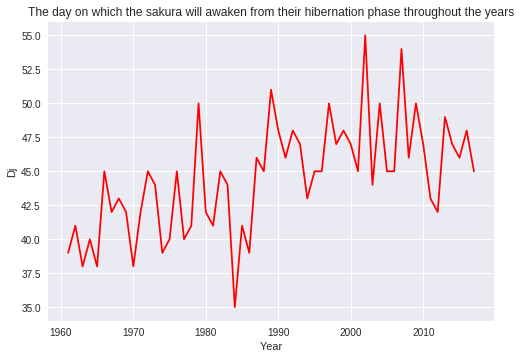

In [329]:
plt.plot(range(1961, 2018), D_j, "r-")
plt.xlabel('Year')
plt.ylabel('Dj')
plt.title('The day on which the sakura will awaken from their hibernation phase throughout the years')
plt.show()

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


In [330]:
print('DTS_j and DTS_mean in corresponding to E_a:')
predictor_2rd.get_df_DTS_j()[0:5] #Only some rows of the dataframe

DTS_j and DTS_mean in corresponding to E_a:


,E_a,mean,1961,1962,1963,1964,1965,1967,1968,1969,...,2007,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,20920.0,31.361525,37.996804,37.281018,38.590530,38.223371,38.773097,35.305076,34.526647,40.382046,...,19.584259,23.438440,26.941472,33.005103,36.576333,20.338842,28.326576,27.733703,25.709285,26.732239
1,25104.0,29.668452,35.722491,35.184231,36.261813,35.852379,36.305868,33.416031,32.655686,38.176891,...,18.668784,22.340946,25.764152,31.190582,34.529019,19.407279,26.882035,26.346091,24.489500,25.343001
2,29288.0,28.078811,33.596022,33.214576,34.087897,33.644417,34.001356,31.651596,30.903324,36.115919,...,17.802012,21.305153,24.653661,29.485479,32.606017,18.532612,25.520548,25.035082,23.338160,24.030288
3,33472.0,26.585808,31.607240,31.363918,32.057920,31.587859,31.848484,30.002621,29.261292,34.188726,...,16.981216,20.327348,23.605796,27.882817,30.799343,17.711135,24.237005,23.796181,22.251132,22.789716
4,37656.0,25.183126,29.746717,29.624665,30.161809,29.671936,29.836948,28.460682,27.721934,32.385710,...,16.203832,19.404049,22.616635,26.376083,29.101547,16.939394,23.026623,22.625166,21.224546,21.617157


In [331]:
DTS_mean = predictor_2rd.get_DTS_mean().tolist()
print('DTS mean: ', DTS_mean)

DTS mean:  [31.361525028768458, 29.66845249623946, 28.07881055257437, 26.585808447064398, 25.183125829757277, 23.86487873665328, 22.625588125049145, 21.460150761749297, 20.36381228255484, 19.332142255852432, 18.361011096364305, 17.446568687284397, 16.585224580203555, 15.773629652500839, 15.008659111322531, 14.287396741954504, 13.607120306379432, 12.965288005155726, 12.35952592251245, 11.787616380771912, 11.247487135933746, 10.737201351521055, 10.25494829263778, 9.799034686651389, 9.367876701026532, 8.959992492622996, 8.573995286260539, 8.208586943568694, 7.862551986102987, 7.534752039440733, 7.224120667488162, 6.9296585685531, 6.650429106879544, 6.3855541553165285, 6.1342102266168705, 5.895624872544007]


In [0]:
df_DTS_j = clone(predictor_2rd.get_df_DTS_j())
df_DTS_j.drop(['mean'], axis='columns', inplace=True)

DTS_j value over the years when E_a is chosen from 5 to 25


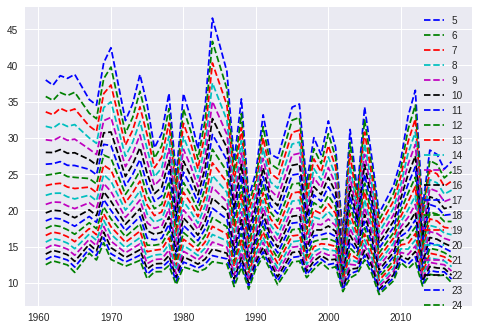

In [333]:
cycol = cycle('bgrcmk')

E_a_range = range(5,25)
fig, ax = plt.subplots()
for idx, row in df_DTS_j.iterrows():
  E_a = int(row['E_a'] / 4184)
  if E_a not in E_a_range:
    continue
  DTS_j = row.tolist()[1:]
  ax.plot(training_years, DTS_j, '--' + next(cycol) , label=str(E_a))

ax.axis('equal')
leg = ax.legend()
print('DTS_j value over the years when E_a is chosen from 5 to 25')
plt.show()

DTS_j value over the years when E_a is chosen from 25 to 40


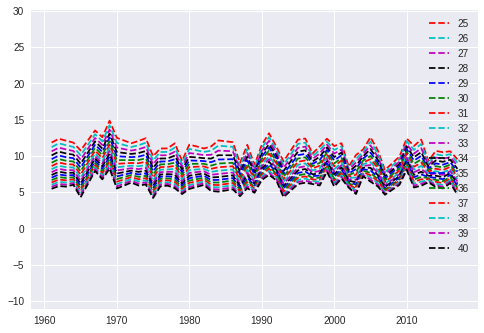

In [334]:
E_a_range = range(25, 40 + 1)
fig, ax = plt.subplots()
for idx, row in df_DTS_j.iterrows():
  E_a = int(row['E_a'] / 4184)
  if E_a not in E_a_range:
    continue
  DTS_j = row.tolist()[1:]
  ax.plot(training_years, DTS_j, '--' + next(cycol) , label=str(E_a))
ax.axis('equal')
leg = ax.legend()
print('DTS_j value over the years when E_a is chosen from 25 to 40')
plt.show()

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

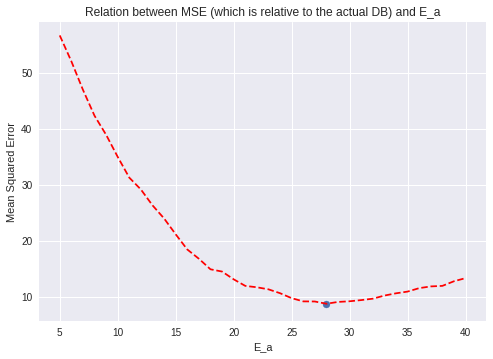

In [335]:
E_a = predictor_2rd.E_a_MSE.keys()
mse = predictor_2rd.E_a_MSE.values()
E_a = predictor_2rd.get_Ea()
E_a_best = predictor_2rd.get_best_Ea()

plt.plot(E_a, mse, 'r--')
plt.scatter(E_a_best, predictor_2rd.E_a_MSE[E_a_best*4184])
plt.xlabel('E_a')
plt.ylabel('Mean Squared Error')
plt.title('Relation between MSE (which is relative to the actual DB) and E_a')
plt.show()

In [336]:
print('The best E_a found: ', predictor_2rd.get_best_Ea()) 

The best E_a found:  28.0


### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [345]:
BD_j = [predictor_2rd.predict(year) for year in testing_years]
BD_2nd_problem = BD_j # For later
print('Predicted blooming date for years in testing years:\n', BD_j)

Predicted blooming date for years in testing years:
 [78, 87, 91, 90, 82]


In [0]:
def get_BD_actual(year):
  start = date_t(year, 1, 1)
  month = tokyo_bloom_date_data_dict[year][0]
  day = tokyo_bloom_date_data_dict[year][1]
  end = date_t(year, month, day)
  return get_num_day_between(start, end)

In [339]:
BD_actual = [get_BD_actual(year) for year in testing_years]
print('Actual blooming date for years in testing years:\n', BD_actual)

Actual blooming date for years in testing years:
 [78, 88, 92, 89, 81]


In [340]:
print('Compute R2 score using self-implemented function:')
print('R2 Score for Problem 2: ', r2_score(BD_actual, BD_j))

Compute R2 score using self-implemented function:
R2 Score for Problem 2:  0.9708454810495627


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

In [0]:
# The model of problem 2 is good and it works perfectly, but I still have some ideas:

# The actual blooming date BD_j depend heavily on the D_j (the day on which the sakura will awaken from their hibernation phase). 
# If we want a correct BD_j, first we must have an accurate D_j.
# The formula of Hayashi et al. (2012) contains too many constants, parameters, and it doesn't give me much confidence.
# We can inprove that formula by finding more suitable constants and providing more accurate input (location, distance..)

# We limit E_a as discrete values with very big step (1 kcal = 4184 joules). 
# If we do regression with biger step (e.g: range(5*4184, 40*4184)), we can find more suitable E_a*

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

In [0]:
# Number of feature per row
NUM_OF_FEATURE = 15
# Max number of date in first 3 month of a year
MAX_NUM_OF_DATE = 91
# Length of input vector of neural network
INPUT_LENGTH = NUM_OF_FEATURE * MAX_NUM_OF_DATE

In [0]:
def get_np_array(year):
  df = df_tokyo_weather[(df_tokyo_weather['year'] == year) & 
                        (df_tokyo_weather['month'] <= 3)].iloc[:,1:]
  arr = list(np.array(df).flatten())
  while len(arr) < INPUT_LENGTH:
    arr = arr + [0]*NUM_OF_FEATURE
  return np.array(arr)

In [0]:
# For each year, I concat all feature of all days in the first 3 months => a vector of size 15*91
X_train = list()
y_train = list()
for year in training_years:
  X_train.append(get_np_array(year))
#   y_train.append(one_hot(get_BD_actual(year), num_classes=366))
  y_train.append(get_BD_actual(year))
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.reshape(len(training_years), INPUT_LENGTH)

In [0]:
X_test = list()
y_test = list()
for year in testing_years:
  X_test.append(get_np_array(year))
#   y_test.append(one_hot(get_BD_actual(year), num_classes=366))
  y_test.append(get_BD_actual(year))
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.reshape(len(testing_years), INPUT_LENGTH)

In [296]:
# Config the structure of my Neural Network
predictor_3rd = Sequential()
predictor_3rd.add(Dense(1000, activation = "sigmoid", input_shape=(INPUT_LENGTH,) ))
predictor_3rd.add(Dropout(rate=0.5))
predictor_3rd.add(Dense(500, activation = "tanh"))
predictor_3rd.add(Dropout(rate=0.1))
predictor_3rd.add(Dense(1))

predictor_3rd.compile(
 optimizer = 'adam',
 loss = "mean_squared_error",
 metrics = ["accuracy"]
)
predictor_3rd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 1000)              1366000   
_________________________________________________________________
dropout_71 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_123 (Dense)            (None, 500)               500500    
_________________________________________________________________
dropout_72 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 501       
Total params: 1,867,001
Trainable params: 1,867,001
Non-trainable params: 0
_________________________________________________________________


In [306]:
num_epochs = 50
bch_sz = 10
# Start the training process
results = predictor_3rd.fit(
 X_train, y_train,
 epochs = num_epochs,
 batch_size = bch_sz,
)

Epoch 1/50
52/52 [==============================] - 0s 923us/step - loss: 38.3072 - acc: 0.0385
Epoch 2/50
52/52 [==============================] - 0s 884us/step - loss: 34.4888 - acc: 0.0385
Epoch 3/50
52/52 [==============================] - 0s 871us/step - loss: 35.8448 - acc: 0.0385
Epoch 4/50
52/52 [==============================] - 0s 904us/step - loss: 38.1492 - acc: 0.0385
Epoch 5/50
52/52 [==============================] - 0s 878us/step - loss: 37.2537 - acc: 0.0385
Epoch 6/50
52/52 [==============================] - 0s 929us/step - loss: 35.8684 - acc: 0.0385
Epoch 7/50
52/52 [==============================] - 0s 918us/step - loss: 37.3091 - acc: 0.0385
Epoch 8/50
52/52 [==============================] - 0s 950us/step - loss: 33.2694 - acc: 0.0192
Epoch 9/50
52/52 [==============================] - 0s 904us/step - loss: 34.4459 - acc: 0.0769
Epoch 10/50
52/52 [==============================] - 0s 1ms/step - loss: 38.0098 - acc: 0.0192
Epoch 11/50
52/52 [======================

In [313]:
y_pred = predictor_3rd.predict(X_test)
BD_3rd_problem = y_pred
BD_actual = y_test
print(y_pred)

[[85.30686]
 [85.30686]
 [85.30686]
 [85.30686]
 [85.30683]]


In [315]:
print('R2 Score for my neural network implementation: ', r2_score(BD_actual, BD_3rd_problem)[0])

R2 Score for my neural network implementation:  -0.0031297207


### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

In [347]:
print('R2 score of 3 problem: ')
print('600 Degree Rule (use T_mean): ', r2_score(BD_actual, BD_1st_problem))
print('DTS method:                   ', r2_score(BD_actual, BD_2nd_problem))
print('Neural network approach:      ', r2_score(BD_actual, BD_3rd_problem)[0])

R2 score of 3 problem: 
600 Degree Rule (use T_mean):  0.8396501457725948
DTS method:                    0.9708454810495627
Neural network approach:       -0.0031297207


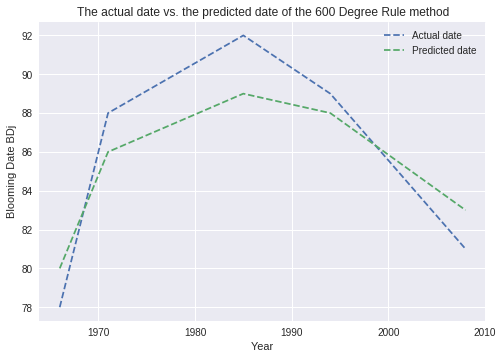

In [355]:
plt.plot(testing_years, BD_actual, '--', label = "Actual date")
plt.plot(testing_years, BD_1st_problem, '--',label = "Predicted date")
plt.xlabel('Year')
plt.ylabel('Blooming Date BDj')
plt.title('The actual date vs. the predicted date of the 600 Degree Rule method')
plt.legend()
plt.show()

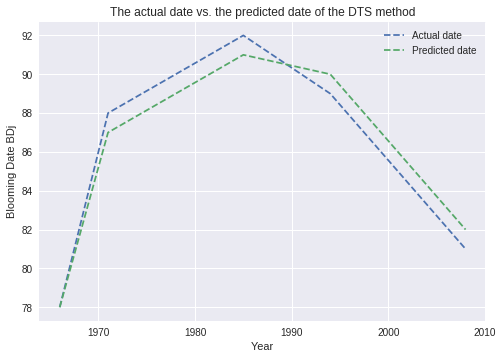

In [356]:
plt.plot(testing_years, BD_actual, '--', label = "Actual date")
plt.plot(testing_years, BD_2nd_problem, '--',label = "Predicted date")
plt.xlabel('Year')
plt.ylabel('Blooming Date BDj')
plt.title('The actual date vs. the predicted date of the DTS method')
plt.legend()
plt.show()

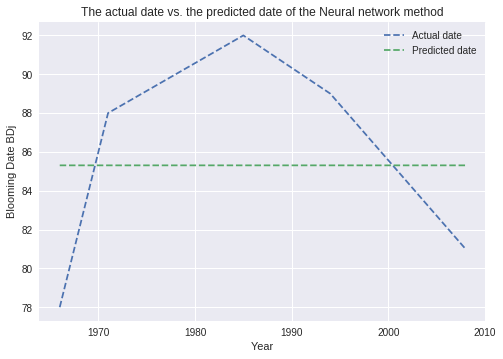

In [357]:
plt.plot(testing_years, BD_actual, '--', label = "Actual date")
plt.plot(testing_years, BD_3rd_problem, '--',label = "Predicted date")
plt.xlabel('Year')
plt.ylabel('Blooming Date BDj')
plt.title('The actual date vs. the predicted date of the Neural network method')
plt.legend()
plt.show()

In [0]:
# Some comment about the 3 methods:

# 600 degree Rule: not axactly accurate but acceptable

# DTS method: really good

# Neural Network: i don't know why my neural network does not work well.
# Maybe we need more data for this method (currently training size is 52, test size is 5)  

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

In [0]:
Dj_all = [predictor_2rd.get_Dj(y) for y in range(1961, 2018)]

No handles with labels found to put in legend.


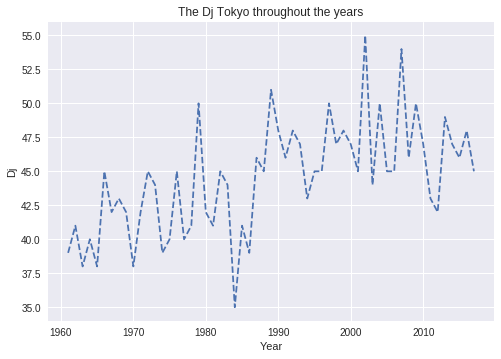

In [364]:
plt.plot(range(1961, 2018), Dj_all, '--')
plt.xlabel('Year')
plt.ylabel('Dj')
plt.title('The Dj Tokyo throughout the years')
plt.legend()
plt.show()

In [0]:
# The last day of sakura hibernation phase tends to occur later and later now

In [0]:
BD_actual_all = [get_BD_actual(y) for y in range(1961, 2018)] 

No handles with labels found to put in legend.


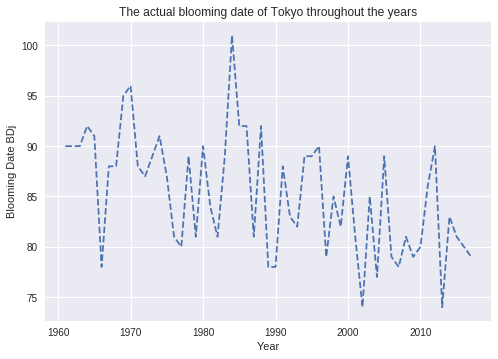

In [361]:
plt.plot(range(1961, 2018), BD_actual_all, '--')
plt.xlabel('Year')
plt.ylabel('Blooming Date BDj')
plt.title('The actual blooming date of Tokyo throughout the years')
plt.legend()
plt.show()

In [0]:
# We can see that the actual BD fluctuated dramatically  but it tend to decrease nowaday
# The sakura these day tend to bloom sooner than they were in the 60s, 70s